# ML Term Paper - Code: Models
by Ann-Christin and Sarah 15/02/2021

## 1. Preparation

In [80]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split


from sklearn import ensemble
from sklearn import tree as tree

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import os
path = "E:\Data\krea\PIAAC"
os.chdir(path)
print("done")
data = pd.read_csv("data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


E:\Anaconda3\envs\base-krea\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (1,2,5,6,13,19,24,26,27,30,32,33,40,49,52,59,60,61,64,65,67,70,77,86,87,88,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(230691, 133)

In [3]:
data.describe()

,Unnamed: 0,inpiaac,seqid,age_r,j_q03b,j_q03b_c,racethn_5cat,yrsqual,yrsqual_t,yrsget,...,readytolearn,icthome,ictwork,earnmthallppp,earnmthbonusppp,earnmthselfppp,nfehrsnjr,nfehrsjr,nfehrs,unempflag
count,230691.000000,3660.000000,230691.000000,166949.000000,103091.000000,144543.000000,3472.000000,218593.000000,213568.000000,125736.000000,...,226734.000000,171755.000000,102478.000000,8.850800e+04,7.677600e+04,11732.000000,54687.000000,54687.000000,80121.000000,3477.000000
mean,115345.000000,0.900546,4401.442982,39.687485,2.258296,2.165992,2.247408,12.536184,12.546814,12.567069,...,2.037301,2.028157,2.016022,3.157575e+03,3.259009e+03,2493.775348,55.298554,84.441805,140.938755,0.039689
std,66594.899812,0.299311,4735.160301,14.302125,1.264413,0.940666,0.982485,3.289158,3.300026,3.516878,...,1.024525,1.008360,1.021538,6.821093e+04,7.313718e+04,9771.976917,198.082778,196.587656,301.342789,0.195257
min,0.000000,0.000000,1.000000,16.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.000000,...,-1.074991,-1.209050,0.008980,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57672.500000,1.000000,1649.000000,27.000000,1.000000,1.000000,2.000000,11.000000,11.000000,11.000000,...,1.355049,1.338901,1.210520,9.259300e+02,1.016686e+03,200.162500,0.000000,9.000000,16.000000,0.000000
50%,115345.000000,1.000000,3298.000000,39.000000,2.000000,2.000000,2.000000,12.000000,12.000000,13.000000,...,1.992110,2.088670,1.854941,1.790609e+03,1.864409e+03,1014.449100,0.000000,30.000000,40.000000,0.000000
75%,173017.500000,1.000000,5008.000000,52.000000,3.000000,3.000000,2.000000,15.000000,15.000000,15.000000,...,2.588965,2.683840,2.624086,3.177483e+03,3.212351e+03,2827.312600,20.000000,80.000000,112.000000,0.000000
max,230690.000000,1.000000,27285.000000,65.000000,25.000000,4.000000,6.000000,23.000000,23.000000,23.000000,...,4.643640,7.710160,5.463352,1.187756e+07,1.187756e+07,856174.200000,1920.000000,1920.000000,1920.000000,1.000000


In [4]:
data.head()


,Unnamed: 0,cntry,cntry_e,inpiaac,seqid,cnt_brth,birthrgn,ageg10lfs,age_r,gender_r,...,nfe12jr,nfe12njr,fnfaet12,fnfaet12jr,fnfaet12njr,nfehrsnjr,nfehrsjr,nfehrs,nopaidworkever,unempflag
0,0,USA,USA,1.0,9355.0,NaN,NaN,NaN,NaN,Male,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
1,1,USA,USA,1.0,10882.0,NaN,NaN,NaN,NaN,Male,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,30.0,30.0,Has had paid work,0.0
2,2,USA,USA,1.0,12329.0,NaN,NaN,NaN,NaN,Female,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
3,3,USA,USA,1.0,10711.0,NaN,NaN,NaN,NaN,Female,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,NaN,NaN,8.0,Has had paid work,0.0
4,4,USA,USA,1.0,10383.0,NaN,NaN,NaN,NaN,Male,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,80.0,80.0,Has had paid work,0.0


In [5]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'cntry', 'cntry_e', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",



dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [8]:
dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')

In [9]:
#thresh = len(dcl) * .18
#dcl.dropna(thresh = thresh, axis = 1, inplace = True)
dcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 79 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   birthrgn            186710 non-null  object 
 1   age_r               166949 non-null  float64
 2   gender_r            230689 non-null  object 
 3   j_q03b              103091 non-null  float64
 4   j_q04a              228012 non-null  object 
 5   pared               215610 non-null  object 
 6   computerexperience  227980 non-null  object 
 7   yrsget              125736 non-null  float64
 8   vet                 102508 non-null  object 
 9   edcat8              188436 non-null  object 
 10  leaver1624          43455 non-null   object 
 11  b_q01b              168921 non-null  object 
 12  b_q02a              228146 non-null  object 
 13  b_q02a_t1           223151 non-null  object 
 14  b_q02a_t2           223143 non-null  object 
 15  b_q04a              183657 non-nul

In [10]:
cate = dcl.select_dtypes(include=['object'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['b_q01b',
 'b_d12h',
 'd_q06c',
 'g_q06',
 'b_q16',
 'nopaidworkever',
 'gender_r',
 'd_q04',
 'd_q05a2',
 'b_q02a_t1',
 'b_q02a_t2',
 'leaver1624',
 'b_q15a',
 'f_q07b',
 'isic1c',
 'computerexperience',
 'b_q15c',
 'b_q10c',
 'g_q05a',
 'b_q12g',
 'b_q12c',
 'd_q09',
 'g_q05e',
 'g_q05g',
 'f_q07a',
 'b_q12e',
 'j_q03a',
 'pared',
 'b_q10a',
 'b_q11',
 'j_q04a',
 'b_q14a',
 'b_q04a',
 'b_q02a',
 'd_q12c',
 'd_q07a',
 'birthrgn',
 'b_q10b',
 'g_q05f',
 'g_q07',
 'b_q14b',
 'edcat8',
 'b_q12a',
 'b_q26a_t',
 'd_q06a',
 'b_q26b',
 'g_q04',
 'g_q08',
 'd_q06b',
 'd_q14',
 'b_q13',
 'd_q03',
 'g_q05h',
 'b_q15b',
 'd_q12a',
 'd_q12b',
 'd_q13c',
 'g_q05d',
 'c_q02a',
 'c_d06',
 'vet',
 'd_q04_t',
 'b_q20b',
 'h_q05g',
 'b_q05c',
 'g_q05c']

In [11]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,"b_q01b_Engineering, manufacturing and construction",b_q01b_General programmes,b_q01b_Health and welfare,"b_q01b_Humanities, languages and arts","b_q01b_Science, mathematics and computing",b_q01b_Services,"b_q01b_Social sciences, business and law",b_q01b_Teacher training and education science,b_d12h_Respondent reported 1 learning activity,b_d12h_Respondent reported learning activities but number is not known,...,b_q20b_Up to half of the time,h_q05g_Every day,h_q05g_Less than once a month,h_q05g_Less than once a week but at least once a month,h_q05g_Never,b_q05c_Yes,g_q05c_Every day,g_q05c_Less than once a month,g_q05c_Less than once a week but at least once a month,g_q05c_Never
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
230687,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230688,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
230689,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [12]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 276 entries, b_q01b_Engineering, manufacturing and construction to skill_3
dtypes: uint8(276)
memory usage: 60.7 MB


In [13]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [14]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   d_q16b         71135 non-null   float64
 6   readytolearn   226734 non-null  float64
 7   earnmthallppp  88508 non-null   float64
dtypes: float64(8)
memory usage: 14.1 MB


In [15]:
num_list = list(set(num))
num_list

['yrsget',
 'c_q09',
 'd_q16b',
 'age_r',
 'j_q03b',
 'c_q10a',
 'readytolearn',
 'earnmthallppp']

In [16]:
# define X and y
on_job = dcl["b_q12d"] #define y here
open_educ = dcl["b_q12b"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,d_q16b,readytolearn,earnmthallppp,...,h_q05g_Less than once a week but at least once a month,h_q05g_Never,b_q05c_Yes,g_q05c_Every day,g_q05c_Less than once a month,g_q05c_Less than once a week but at least once a month,g_q05c_Never,skill_1,skill_2,skill_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,2.164922,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1.177736,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
230687,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,2.156445,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230688,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,2.383062,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
230689,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,1.751830,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
on_job.describe()

count    46750.000000
mean         3.252021
std          4.441589
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         50.000000
Name: b_q12d, dtype: float64

In [18]:
open_educ.describe()

count    16053.000000
mean         2.517660
std          3.785557
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         50.000000
Name: b_q12b, dtype: float64

## 2. OLS
### 2.1 OLS 'on the job training'

In [19]:
# run OLS on job
import statsmodels.api as sm

nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()
y = nona["on_job"]
X = nona.iloc[:, 1:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 on_job   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     8.565
Date:                Fri, 26 Feb 2021   Prob (F-statistic):          1.20e-284
Time:                        12:25:54   Log-Likelihood:                -40584.
No. Observations:               14761   AIC:                         8.169e+04
Df Residuals:                   14498   BIC:                         8.369e+04
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                          -0.0400      0.007     -5.843      0.000      -0.053      -0.027
j_q03b                                                                                          0.0086      0.034      0.253      0.800      -0.058       0.075
yrsget                                                                                          0.0153      0.033      0.468      0.640      -0.049       0.079
c_q09                                                                                           0.0331      0.006      5.218      0.000       0.021       0.046
c_q10a                                                                                          0.0607      0.024      2.489      0.013       0.013       0.108
d_q16b                                                                                      -3.584e-09      6e-09     -0.597      0.550   -1.53e-08    8.18e-09
readytolearn                                                                                    0.1025      0.038      2.719      0.007       0.029       0.176
earnmthallppp                                                                                2.393e-06   2.22e-06      1.076      0.282   -1.97e-06    6.75e-06
b_q01b_Engineering, manufacturing and construction                                             -0.2072      0.160     -1.296      0.195      -0.521       0.106
b_q01b_General programmes                                                                      -0.2779      0.171     -1.621      0.105      -0.614       0.058
b_q01b_Health and welfare                                                                       0.4142      0.187      2.214      0.027       0.047       0.781
b_q01b_Humanities, languages and arts                                                          -0.2069      0.193     -1.073      0.283      -0.585       0.171
b_q01b_Science, mathematics and computing                                                       0.0305      0.180      0.169      0.866      -0.323       0.384
b_q01b_Services                                                                                -0.0968      0.202     -0.480      0.631      -0.492       0.299
b_q01b_Social sciences, business and law                                                       -0.1803      0.162     -1.113      0.266      -0.498       0.137
b_q01b_Teacher training and education science                                                   0.0292      0.189      0.155      0.877      -0.341       0.400
b_d12h_Respondent reported 1 learning activ

### 2.2 OLS 'open education'

In [20]:
# run OLS open educ
import statsmodels.api as sm

nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()
y = nona["open_educ"]
X = nona.iloc[:, 2:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              open_educ   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.145
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           2.57e-21
Time:                        12:25:56   Log-Likelihood:                -11138.
No. Observations:                4092   AIC:                         2.279e+04
Df Residuals:                    3834   BIC:                         2.442e+04
Df Model:                         257                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
j_q03b                                                                                         -0.0801      0.068     -1.174      0.240      -0.214       0.054
yrsget                                                                                         -0.0773      0.070     -1.107      0.268      -0.214       0.060
c_q09                                                                                           0.0101      0.008      1.305      0.192      -0.005       0.025
c_q10a                                                                                          0.0367      0.052      0.709      0.479      -0.065       0.138
d_q16b                                                                                       1.916e-09   7.58e-09      0.253      0.801    -1.3e-08    1.68e-08
readytolearn                                                                                    0.1528      0.069      2.220      0.026       0.018       0.288
earnmthallppp                                                                               -2.669e-06   2.85e-06     -0.935      0.350   -8.26e-06    2.93e-06
b_q01b_Engineering, manufacturing and construction                                              0.2875      0.344      0.835      0.404      -0.387       0.962
b_q01b_General programmes                                                                      -0.0293      0.378     -0.078      0.938      -0.770       0.712
b_q01b_Health and welfare                                                                       0.7709      0.382      2.020      0.043       0.023       1.519
b_q01b_Humanities, languages and arts                                                           0.2852      0.383      0.745      0.456      -0.465       1.036
b_q01b_Science, mathematics and computing                                                       0.5209      0.369      1.410      0.159      -0.203       1.245
b_q01b_Services                                                                                 0.7873      0.431      1.827      0.068      -0.058       1.632
b_q01b_Social sciences, business and law                                                        0.2395      0.340      0.704      0.481      -0.427       0.906
b_q01b_Teacher training and education science                                                   0.1386      0.378      0.367      0.714      -0.602       0.879
b_d12h_Respondent reported 1 learning activity                                                 -0.3656      0.602     -0.607      0.544      -1.547       0.815
b_d12h_Respondent reported learning activit

#### Interpretation of first OLS results
OLS of open education indicates that high-skilled are more likely compared to lower skilled occuopatons to participate in open education.
OLS of on the job training indicates that high-skilled are less likely to particpate comapred to low skill levels. However, the ceofficients are not significant for the open education. Possible problem might be collinearity in the data set. Using Machine Learning techniques like Lasso, we should be able to eliminate the irrelevant explanatory variables and get a better fit.


Get some insights by looking at the variable distributions and at the pairwise relationships between them. Only numerical variables will be used. In the following plot, each dot represents a sample.

import seaborn as sns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)
train_dataset = X_train.copy()
train_dataset.insert(0, "open_educ", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

## 3. Feature selection with Benjamini - Hochberg Algorithm

In [21]:
# FDR selection:  Benjamini - Hochberg as a first attempt to regularise the model

from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
print('done')

done


### 3.1 On the job training

In [55]:
nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()

y = nona["on_job"]
X = nona.iloc[:, 1:]

# Now let's apply Benjamini - Hochberg as a first attempt to regularise the model 
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

In [56]:
fdr = SelectFdr(f_regression, alpha=0.05) 
# here alpha is our acceptable rate of finding false positives 
X_new =fdr.fit_transform(X, y) 

E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [57]:
print(X.shape, X_new.shape)

(14761, 221) (14761, 125)


In [58]:
# Cutoff pvalue for selected features 
sorted = pd.Series(fdr.pvalues_.T).sort_values(axis=0, ascending=True).reset_index(drop = True)
print("Cutoff p-value: % .4f" % sorted.loc[X_new.shape[1]])

Cutoff p-value:  0.0289


In [59]:
print(X_new.shape[1])

125


In [60]:
print(sorted)

0      1.723570e-234
1      3.451547e-232
2       3.342143e-86
3       5.090582e-78
4       2.100535e-35
           ...      
216              NaN
217              NaN
218              NaN
219              NaN
220              NaN
Length: 221, dtype: float64


<AxesSubplot:title={'center':'Ordered p-values'}, xlabel='Coefficients ranked by p-value', ylabel='P-value'>

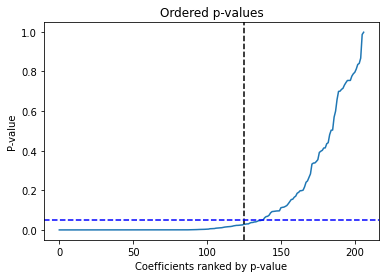

In [61]:
# Plot ordered pvalues
ax = sorted.plot.line(title = "Ordered p-values")
ax.set(xlabel="Coefficients ranked by p-value", ylabel="P-value")
ax.axvline(X_new.shape[1], color='k', linestyle='--')
ax.axhline(0.05, color='b', linestyle='--', label = 'p-value = 0.1')
ax

In [62]:

# ! it is more correct to perform FDR only on the train data, therefore it is inside the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.1)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set


In [63]:
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train)) #In sample fit decreases afte throughing out variables
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test)) # Out of sample fit decresaed

E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In-sample Rsq:  0.1451
Out-of-sample Rsq:  0.0756


In [64]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[0.06292901 0.08870729 0.08774405 0.10919816 0.07921077]
Accuracy: 0.08556 (+/- 0.03001)


In [73]:
y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print("scores_reduced")
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


scores_reduced
[0.064215   0.09019099 0.08687772 0.11057928 0.0859218 ]
Accuracy: 0.08756 (+/- 0.02946)


E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [68]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0269 
Training time =  9.2040s 


In [69]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.0789388  0.1029754  0.09622062]
Accuracy: 0.09271 (+/- 0.02024)


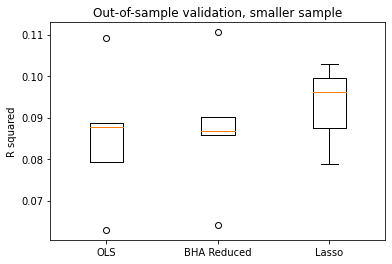

In [74]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced, scores_lasso])
plt.xticks([1, 2, 3], ['OLS', 'BHA Reduced', 'Lasso'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation, smaller sample')
plt.savefig('plots\outofsample_validation.png', bbox_inches='tight')


NOTE: out-of-sample performance of regularized models appears to be better--> less noise in the data and thus no overfitting.

Text(0.5, 1.0, 'Out-of-sample validation')

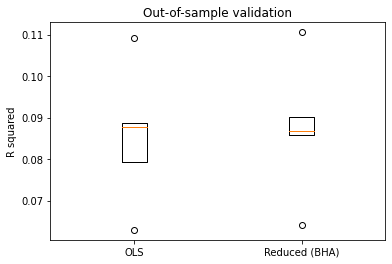

In [75]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced])
plt.xticks([1, 2], ['OLS', 'Reduced (BHA)'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

### 3.2. Open Education

In [22]:
nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()

y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Now let's apply Benjamini - Hochberg as a first attempt to regularise the model 
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

In [23]:
fdr = SelectFdr(f_regression, alpha=0.05) 
# here alpha is our acceptable rate of finding false positives 
X_new =fdr.fit_transform(X, y) 

E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [24]:
print(X.shape, X_new.shape)

(4092, 284) (4092, 27)


In [25]:
# Cutoff pvalue for selected features 
sorted = pd.Series(fdr.pvalues_.T).sort_values(axis=0, ascending=True).reset_index(drop = True)
print("Cutoff p-value: % .4f" % sorted.loc[X_new.shape[1]])

Cutoff p-value:  0.0068


In [26]:
print(X_new.shape[1])

27


In [27]:
print(sorted)

0      1.593248e-23
1      3.388215e-23
2      9.631746e-14
3      3.881892e-08
4      3.282158e-07
           ...     
279             NaN
280             NaN
281             NaN
282             NaN
283             NaN
Length: 284, dtype: float64


<AxesSubplot:title={'center':'Ordered p-values'}, xlabel='Coefficients ranked by p-value', ylabel='P-value'>

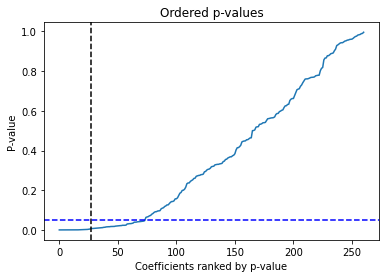

In [28]:
# Plot ordered pvalues
ax = sorted.plot.line(title = "Ordered p-values")
ax.set(xlabel="Coefficients ranked by p-value", ylabel="P-value")
ax.axvline(X_new.shape[1], color='k', linestyle='--')
ax.axhline(0.05, color='b', linestyle='--', label = 'p-value = 0.1')
ax

In [29]:
# ! it is more correct to perform FDR only on the train data, therefore it is inside the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.1)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set


In [30]:
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train)) #In sample fit decreases afte throughing out variables
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test)) # Out of sample fit decresaed

In-sample Rsq:  0.0801
Out-of-sample Rsq: -0.0064


E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [31]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["open_educ"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[-7.47648825e-02 -2.16099151e-01  8.43712572e-03 -1.14253853e+23
 -5.63495687e+18]
Accuracy: -22851897504562247892992.00000 (+/- 91401955165593738936320.00000)


In [32]:
y = nona["open_educ"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print("scores_reduced")
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
E:\Anaconda3\envs\base-krea\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


scores_reduced
[ 0.01059321 -0.02043558  0.0308602   0.03418046 -0.01447529]
Accuracy: 0.00814 (+/- 0.04497)


In [35]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
import time
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.1649 
Training time =  1.0041s 


In [36]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.03096943 0.03226356 0.02552565 0.02234608 0.0245278 ]
Accuracy: 0.02713 (+/- 0.00766)


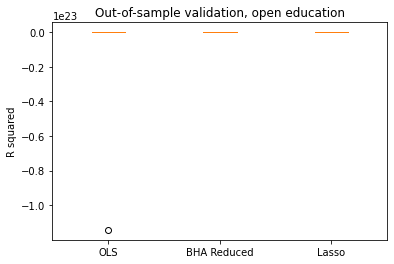

In [38]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced, scores_lasso])
plt.xticks([1, 2, 3], ['OLS', 'BHA Reduced', 'Lasso'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation, open education')
plt.savefig('plots\outofsample_validation_openEduc.png', bbox_inches='tight')


## 4. Lasso
### 4.1 Lasso - on the job training

In [40]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()

y = nona["on_job"]
X = nona.iloc[:, 1:]



# Now let's apply Benjamini - Hochberg as a first attempt to regularise the model 
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1234
Out-of-sample Rsq:  0.0685


old result: 
In-sample Rsq:  0.1315
Out-of-sample Rsq:  0.0692

Computing regularization path using the lasso...
Ready


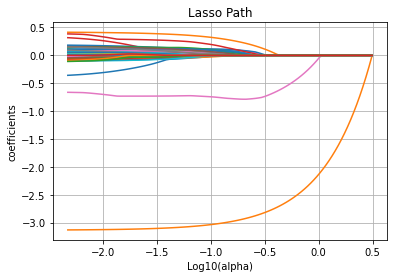

<Figure size 432x288 with 0 Axes>

In [41]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.grid(axis='both')
plt.show()

plt.savefig('plots\lasso_path_onJob.png', bbox_inches='tight')

Lasso Path shows the path of estimated coefficients for different values of $\lambda$. When $\lambda$ approaches zero, we are close to the OLS with all the variables. The path also shows us the $\lambda$ when all the coefficients are zero (null model). For this graph such $\lambda$ is around log(-1). It is helpful for the next step, when we define the search grid to find the optimal $\lambda$. 
#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [45]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  10.2043s 


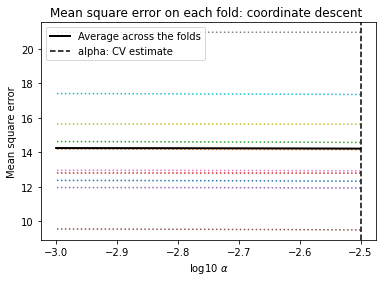

In [46]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.savefig('plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')

MSE is almost constant for 10 folds.

In [47]:


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1426
Out-of-sample Rsq:  0.0639


In [51]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-0.37220045,  0.00643616,  0.09434618,  0.33317669,  0.10587791,
       -0.04687805,  0.1015778 ,  0.04573737, -0.09159654, -0.0508528 ,
        0.086956  , -0.03594083,  0.01415793, -0.05241639, -0.06177748,
       -0.05449218, -0.65206772,  0.02029179,  0.        ,  0.        ,
        0.07248596, -0.06522963, -0.1117692 , -0.        ,  0.00130996,
        0.01909183, -0.09450659,  0.        , -0.029262  ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00699795,
        0.        , -0.        , -0.01167275, -0.        , -0.01800316,
       -0.03489997, -0.02908345,  0.0466494 , -0.04922425, -0.02357769,
       -0.01516792, -0.0517374 ,  0.01642956,  0.01365908,  0.00603228,
       -0.01841536, -0.02079364, -0.03379735, -0.00273522, -0.03046228,
        0.02335689, -0.02017421, -0.05131918, -0.01473639, -0.00373516,
       -0.0125529 ,  0.01471048,  0.04310195,  0.0300173 ,  0.0158192 ,
       -0.04289447, -0.00284064, -0.05354735, -0.05455581, -0.03

In [52]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [53]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient
0,-0.372200
1,0.006436
2,0.094346
3,0.333177
4,0.105878
...,...
277,0.156159
278,0.008033
279,0.029338
281,-0.096289


#### Lasso for open education

In [54]:
nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()
y = nona["open_educ"]
X = nona.iloc[:, 2:]

In [55]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

y = nona["open_educ"]
X = nona.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1073
Out-of-sample Rsq:  0.0167


Computing regularization path using the lasso...
Ready


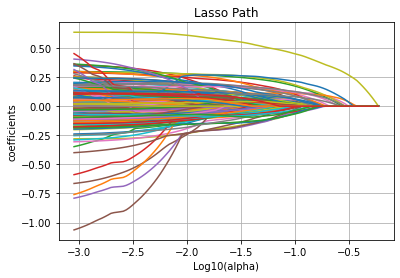

<Figure size 432x288 with 0 Axes>

In [57]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.grid(axis='both')
plt.show()

plt.savefig('plots\lasso_path_openeduc.png', bbox_inches='tight')

In [58]:
#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [59]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  5.5458s 


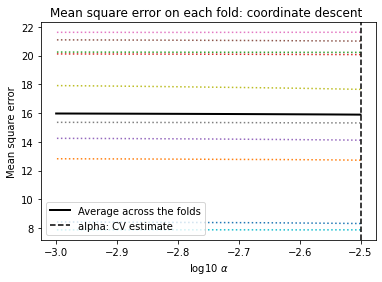

In [60]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.savefig('plots\lasso_MSE_fold_openeduc.png', bbox_inches='tight')

In [61]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1457
Out-of-sample Rsq: -0.0348


In [62]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-2.15695276e-01, -6.97794924e-02, -2.02747586e-01,  3.24985965e-01,
       -1.50237900e-02,  2.50602616e-02,  1.99744613e-01, -6.32025401e-02,
        1.20856883e-01, -2.44108357e-02,  1.44296731e-01,  4.36430142e-02,
        1.07312737e-01,  1.12396172e-01,  5.48390807e-02, -7.59554155e-03,
       -0.00000000e+00, -9.84716804e-03,  6.33655615e-01,  0.00000000e+00,
        2.43140675e-02, -6.82396378e-02, -0.00000000e+00, -3.77162943e-02,
        4.46316062e-02,  3.08004246e-02,  2.14498270e-02,  0.00000000e+00,
       -3.28017126e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.05649909e-02,
       -4.93690020e-02,  0.00000000e+00,  0.00000000e+00, -2.60326318e-03,
       -2.44530524e-02,  1.36212593e-01, -1.78849795e-02, -7.24009564e-02,
       -6.52467751e-02, -3.08399211e-02, -3.19160250e-02,  6.14901867e-02,
        1.86594024e-02,  6.05127608e-03,  8.32727005e-02, -1.64359035e-02,
        2.67793922e-02,  

In [63]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.215695,age_r
1,-0.069779,j_q03b
2,-0.202748,yrsget
3,0.324986,c_q09
4,-0.015024,c_q10a
...,...,...
279,-0.076178,g_q05c_Less than once a week but at least once...
280,0.067996,g_q05c_Never
281,0.059354,skill_1
282,-0.085359,skill_2


In [64]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.215695,age_r
1,-0.069779,j_q03b
2,-0.202748,yrsget
3,0.324986,c_q09
4,-0.015024,c_q10a
...,...,...
279,-0.076178,g_q05c_Less than once a week but at least once...
280,0.067996,g_q05c_Never
281,0.059354,skill_1
282,-0.085359,skill_2


## 5. Random Forest 

### 5.1 Open Education

In [68]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: -0.005
Out-of-sample MSE: 15.329


In [69]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees
from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

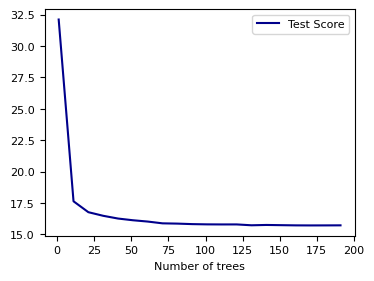

In [70]:


result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

In [71]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.041061,earnmthallppp
1,0.037765,age_r
2,0.032735,d_q16b
3,0.031783,readytolearn
4,0.023903,c_q09
...,...,...
279,0.000000,c_d06_Not known
280,0.000000,d_q05a2_2019.0
281,0.000000,"c_d06_Yes, unpaid work for family business"
282,0.000000,nopaidworkever_Has not has paid work ever


In [77]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 58
Out-of-sample Rsq: -0.759
Out-of-sample MSE: 35.136


### 5.2 On the job training

In [94]:
nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()
y = nona["on_job"]
X = nona.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

In [73]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.086
Out-of-sample MSE: 18.247


In [95]:
# another random forest - but hte other some is better

rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2, oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.071
Out-of-sample MSE: 18.550


In [74]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees
from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

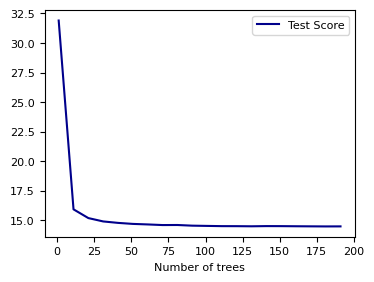

In [75]:
result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 25 trees. 

In [76]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.051202,earnmthallppp
1,0.040601,b_d12h_Respondent reported 1 learning activity
2,0.040290,readytolearn
3,0.038752,d_q16b
4,0.030466,c_q09
...,...,...
278,0.000000,"d_q04_t_Self-employed, not supervisor"
279,0.000000,d_q05a2_2019.0
280,0.000000,d_q05a2_1963.0
281,0.000000,"c_d06_Yes, unpaid work for family business"


#### Regular Tree

In [78]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 58
Out-of-sample Rsq: -0.718
Out-of-sample MSE: 34.302


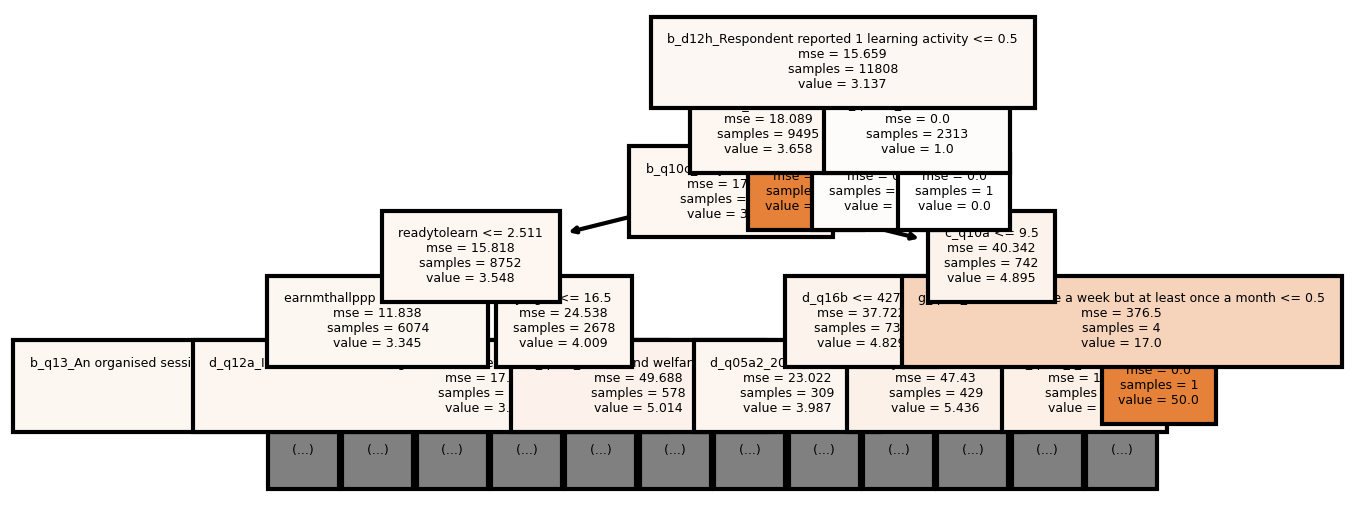

In [81]:
#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

###  Pruning with Minimal Cost-Complexity

This pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. 
The goal is the find an optimal value of α which gives the maximum validation/test set accuracy.

- Parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 

- The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)

In [87]:
# Complexity path 
cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

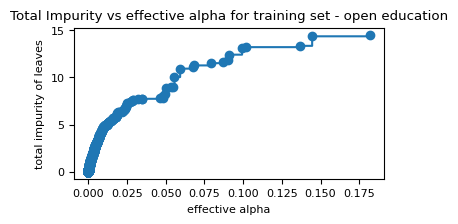

In [89]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set - open education")
plt.savefig('plots\costcomplexPruning_openeduc.png', bbox_inches='tight')
# Based on this graph, where would you expect the optimal alpha to be? 

As it is evident from the above plot, a value of alpha close to 0 corresponds to minimum impurity(unpruned tree) and as the value of alpha becomes larger the tree tends to be more impure.

In [90]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

9.000000000000002e-05

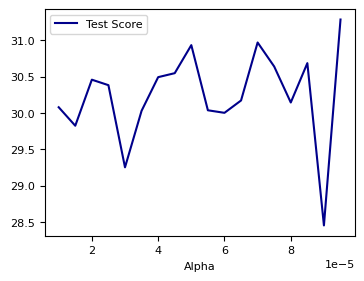

In [91]:
# attention: this CV takes some time, as we are fitting many forests, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 57
Out-of-sample Rsq: -0.707
Out-of-sample MSE: 34.091


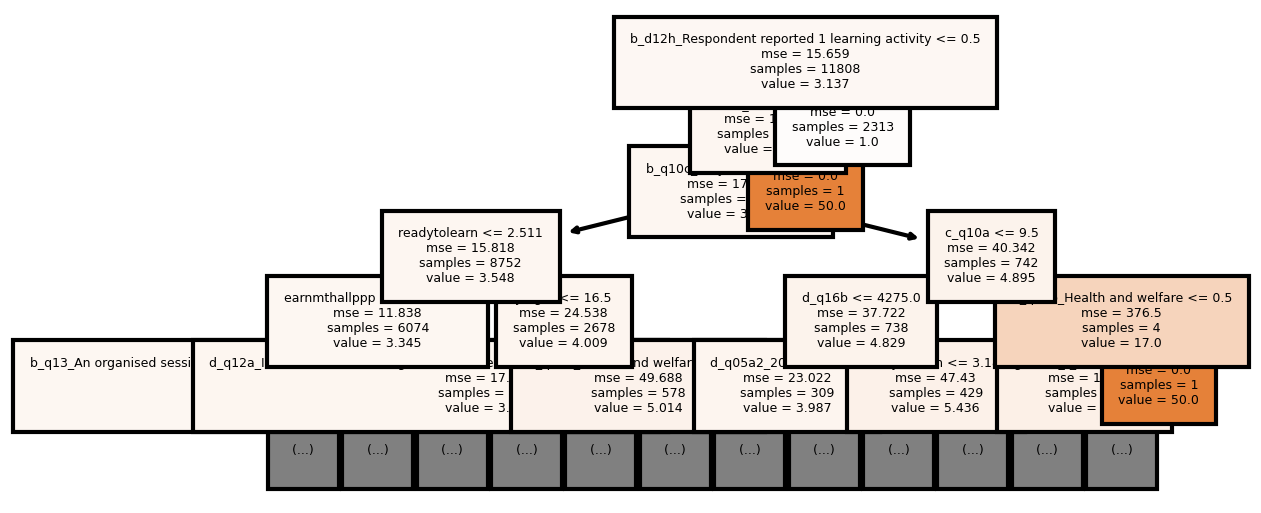

In [93]:
# put here the parameter for ccp_alpha that you determined in the previous step 

cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);